# Standalone Bank Offer Notebook

### Prediction on Customer Enrollment Dataset with Amazon SageMaker 

### Background

Direct marketing, either through mail, email, phone, etc., is a common tactic to acquire customers. Because resources and a customer's attention is limited, the goal is to only target the subset of prospects who are likely to engage with a specific offer. Predicting those potential customers based on readily available information like demographics, past interactions, and environmental factors is a common machine learning problem.


### Business problem: 
Predict whether a customer will enroll for a certificate of deposit product at a bank, after one or more phone calls.

### Labeled Data: 
Customer demographics (age, employment, type of job, education etc.), responses to marketing events (including past response), external factors (month, day of the week etc.) and whether the customer is enrolled.

### Step 1: Imports

Import libraries and define environment variables

In [26]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer  
import random
import collections
from collections import Counter

In [27]:
# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


### Step 2: Create Storage Bucket

Please note the bucket_name needs to be unique globally for AWS S3, Please enter a first and last name to generate a unique bucket name

#### Unique S3 Bucket Name Generator

In [28]:
def unique_s3_name():
    fname = input('Enter your first name, eg. joe :')
    lname = input('Enter your last name, eg. smith :')
    bucket_name = 'sagemaker-844-'+fname+lname+str(random.randint(100, 999))
    print("Your unique S3 bucket name will be '{}'".format(bucket_name))
    return bucket_name

In [29]:
# eg. bucket_name = 'sagemaker-844-firstnamelastname###' <-- example of a unique bucket name 
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
#        s3.create_bucket(Bucket=bucket_name)
        bucket_name = unique_s3_name()
        s3.create_bucket(Bucket=bucket_name)
    else: 
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

Enter your first name, eg. joe :herb
Enter your last name, eg. smith :dean
Your unique S3 bucket name will be 'sagemaker-844-herbdean423'
S3 bucket created successfully


### Step 3: Download Data
Download data from external URL to your SageMaker instance, and read it as a dataframe.

In [30]:
try:

#    urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
    !wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
    print('Success: downloaded bank-additional.zip!')    
    print('')
except Exception as e:
    print('Data load error: ',e)
    print('')


try:    
    !unzip -o bank-additional.zip    
    print('Success: Unzipped bank-additional.zip to .csv!')    
    print('')    
except Exception as e:
    print('Data load error: ',e)
    print('')
    
try:

    raw_data = pd.read_csv('./bank-additional/bank-additional-full.csv', sep=";")
#    model_data = pd.read_csv('./bank_clean.csv',index_col=0)
    print('Success: Data loaded bank-additional-full.csv into dataframe.')
    print('')
except Exception as e:
    print('Data load error: ',e)
    print('')

--2020-10-27 18:56:11--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘bank-additional.zip’ not modified on server. Omitting download.

Success: downloaded bank-additional.zip!

Archive:  bank-additional.zip
  inflating: bank-additional/.DS_Store  
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  
Success: Unzipped bank-additional.zip to .csv!

Success: Data loaded bank-additional-full.csv into dataframe.



### Step 4: Initial View the Dataset

Now that the dateset is downloaded and in a Pandas dataframe we can look at the data.

Data contains 20 features for each customer. Here is a summary of each column:

Demographics:
* age: Customer's age (numeric)
* job: Type of job (categorical: 'admin.', 'services', ...)
* marital: Marital status (categorical: 'married', 'single', ...)
* education: Level of education (categorical: 'basic.4y', 'high.school', ...)

Past customer events:
* default: Has credit in default? (categorical: 'no', 'unknown', ...)
* housing: Has housing loan? (categorical: 'no', 'yes', ...)
* loan: Has personal loan? (categorical: 'no', 'yes', ...)

Past direct marketing contacts:
* contact: Contact communication type (categorical: 'cellular', 'telephone', ...)
* month: Last contact month of year (categorical: 'may', 'nov', ...)
* day_of_week: Last contact day of the week (categorical: 'mon', 'fri', ...)
* duration: Last contact duration, in seconds (numeric). Important note: If duration = 0 then y = 'no'.

Campaign information:
* campaign: Number of contacts performed during this campaign and for this client (numeric, includes last contact)
* pdays: Number of days that passed by after the client was last contacted from a previous campaign (numeric)
* previous: Number of contacts performed before this campaign and for this client (numeric)
* poutcome: Outcome of the previous marketing campaign (categorical: 'nonexistent','success', ...)

External environment factors:
* emp.var.rate: Employment variation rate - quarterly indicator (numeric)
* cons.price.idx: Consumer price index - monthly indicator (numeric)
* cons.conf.idx: Consumer confidence index - monthly indicator (numeric)
* euribor3m: Euribor 3 month rate - daily indicator (numeric)
* nr.employed: Number of employees - quarterly indicator (numeric)

Target variable:
* y: Has the client subscribed a term deposit? (binary: 'yes','no')

In [31]:
raw_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [32]:
raw_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [33]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Step 5: Exploratory Data Analysis

In [34]:
raw_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

Display the Min and Max of the numeric columns

In [35]:
numeric_colns = ['age', 'duration', 'campaign', 'pdays','previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']
for x in numeric_colns:
    value = np.array(raw_data[x])
    print(x,':', 'min:', np.min(value), 'max:', np.max(value))


age : min: 17 max: 98
duration : min: 0 max: 4918
campaign : min: 1 max: 56
pdays : min: 0 max: 999
previous : min: 0 max: 7
emp.var.rate : min: -3.4 max: 1.4
cons.price.idx : min: 92.20100000000001 max: 94.76700000000001
cons.conf.idx : min: -50.8 max: -26.9
euribor3m : min: 0.634 max: 5.045
nr.employed : min: 4963.6 max: 5228.1


Look at the range of each numeric coiumns

In [36]:
for x in numeric_colns:
    raw_data[x] = raw_data[x].apply(round)
    value = np.array(raw_data[x])
    print(x,':', 'min:', np.min(value), 'max:', np.max(value), raw_data[x].dtype)
    print(raw_data[x].unique())
    print('')

age : min: 17 max: 98 int64
[56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]

duration : min: 0 max: 4918 int64
[ 261  149  226 ... 1246 1556 1868]

campaign : min: 1 max: 56 int64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 37 40 33 34 43]

pdays : min: 0 max: 999 int64
[999   6   4   3   5   1   0  10   7   8   9  11   2  12  13  14  15  16
  21  17  18  22  25  26  19  27  20]

previous : min: 0 max: 7 int64
[0 1 2 3 4 5 6 7]

emp.var.rate : min: -3 max: 1 int64
[ 1  0 -2 -3 -1]

cons.price.idx : min: 92 max: 95 int64
[94 93 92 95]

cons.conf.idx : min: -51 max: -27 int64
[-36 -42 -43 -40 -46 -50 -47 -41 -34 -31 -30 -27 -33 -35 -38 -51]

euribor3m : min: 1 max: 5 int64
[5 4 3 2 1]

nr.employed : min: 4964 max: 5228 int64
[5191 5

Display a couple of Box Plots to show the relation of some categorical columns vs. numeric columns.

e.g. "What is the distribution of ages when someone has 'defaulted' on a loan in the past?"   OR

e.g. "what is the distribution of ages based on the past success or failure of a past loan?"

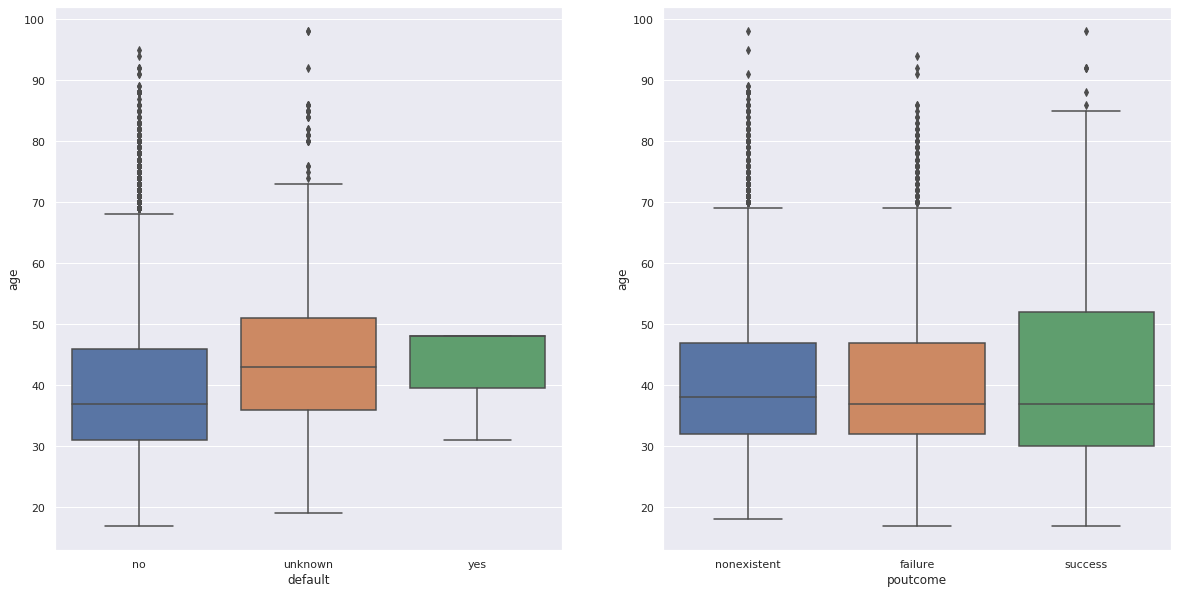

In [37]:
sns.set()
fig = plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
sns.boxplot(x='default', y='age', data=raw_data)
plt.subplot(1, 2, 2)
sns.boxplot(x='poutcome', y='age', data=raw_data)

Display a scatter joint plot to show the relation of some numeric columns vs. numeric columns.

e.g. "What is the Ages vs. the days of a campaign?"

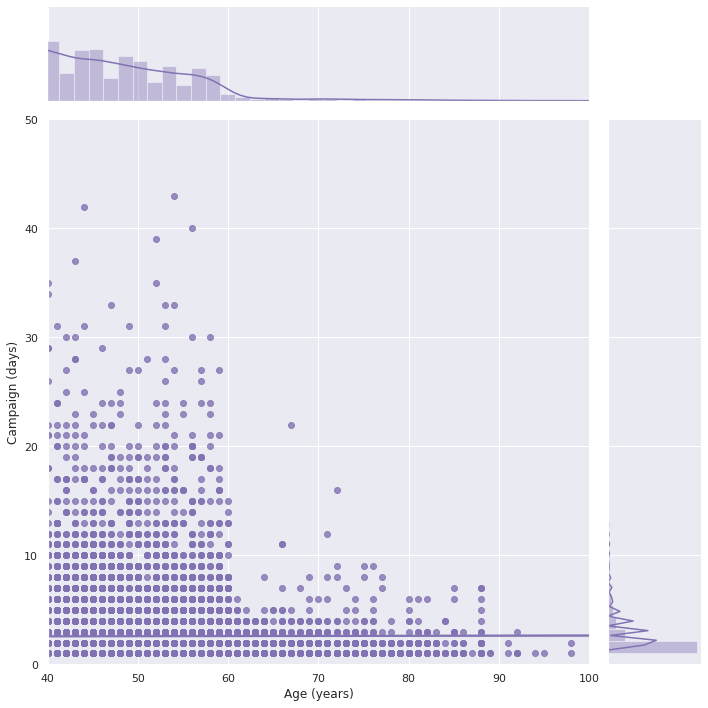

In [38]:
sns.set()
g = sns.jointplot("age", "campaign", data=raw_data,
                  kind="reg", truncate=False,
                  xlim=(40, 100), ylim=(0, 50),
                  color="m", height=10)
g.set_axis_labels("Age (years)", "Campaign (days)")

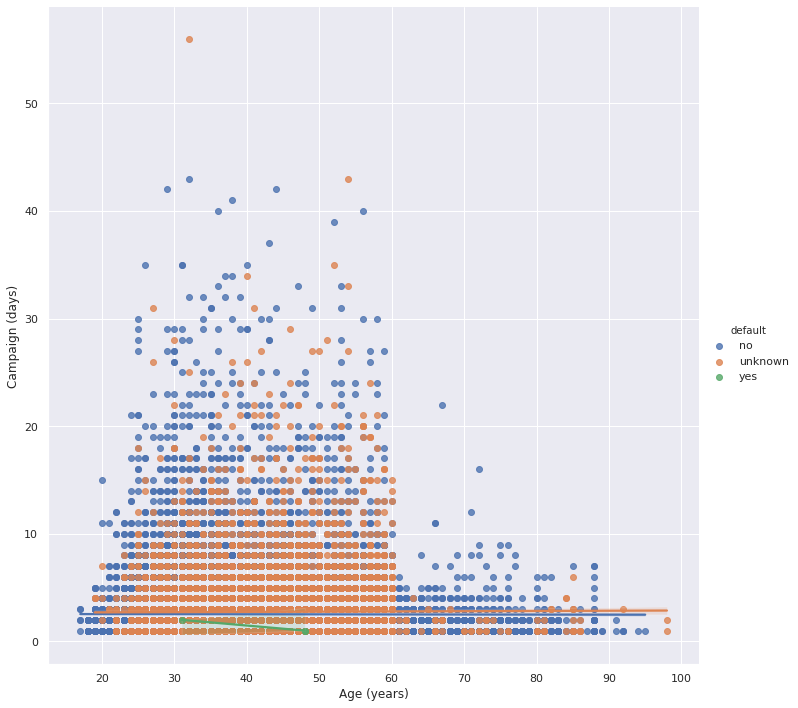

In [39]:
g = sns.lmplot(x="age", y="campaign", hue="default",
               height=10, data=raw_data)
g.set_axis_labels("Age (years)", "Campaign (days)")

Look at the pie chart of the distribution of our dataset in terms of the level of education of our customers.

In [40]:
c = Counter(raw_data['education'])
print(c)

Counter({'university.degree': 12168, 'high.school': 9515, 'basic.9y': 6045, 'professional.course': 5243, 'basic.4y': 4176, 'basic.6y': 2292, 'unknown': 1731, 'illiterate': 18})


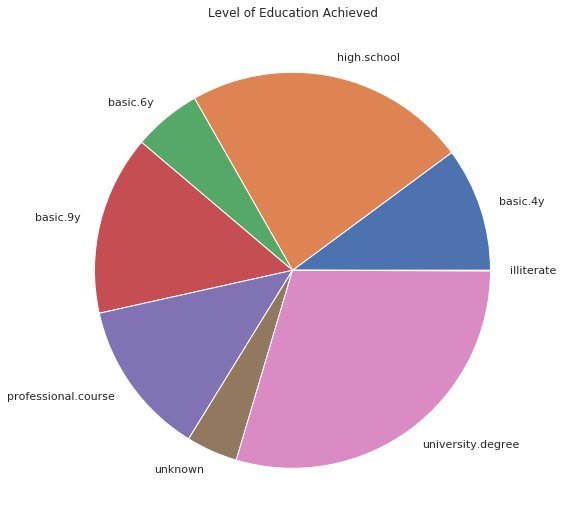

In [41]:
fig = plt.figure(figsize=(8,8))
plt.pie([float(c[v]) for v in c], labels=[str(k) for k in c], autopct=None)
plt.title('Level of Education Achieved') 
plt.tight_layout()

In [42]:
raw_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

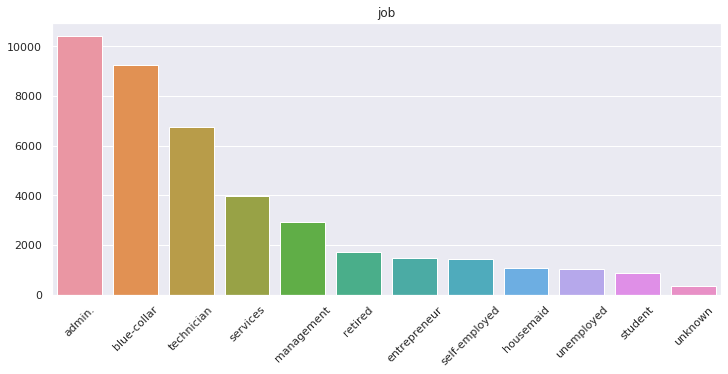

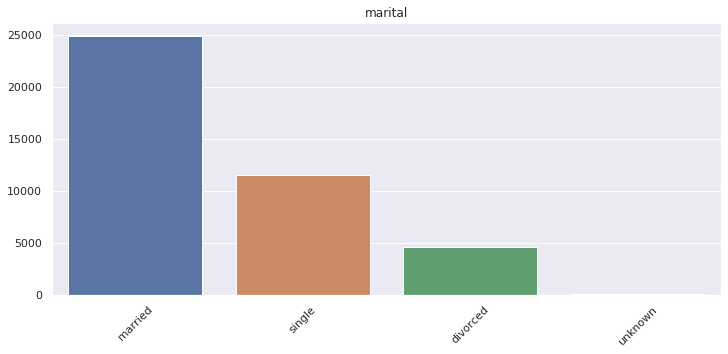

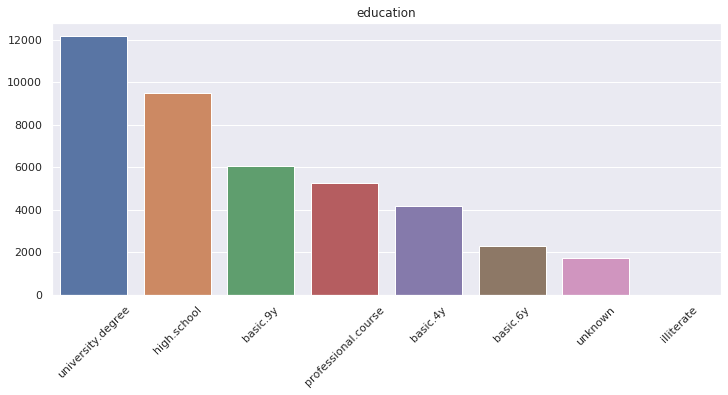

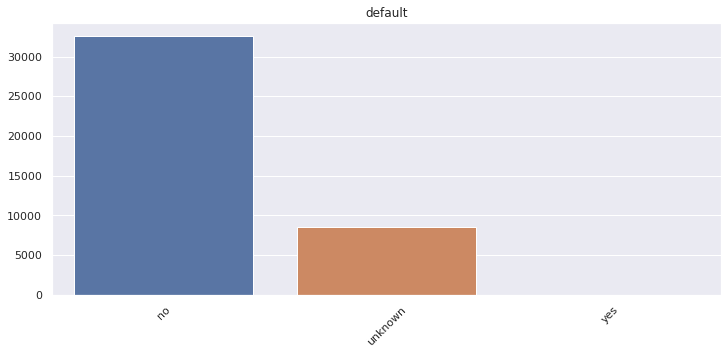

In [43]:
for a in raw_data.columns[1:5]:
    data = raw_data[a].value_counts()
    values = raw_data[a].value_counts().index.to_list()
    counts = raw_data[a].value_counts().to_list()
    
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x = values, y = counts)
    
    plt.title(a)
    plt.xticks(rotation=45)
#    print(a, values, counts)

### Step 6: Data Cleaning

Now that we have explored the data thoroughly, we can now start 'cleaning' the dataset. Let's remind ourselves what we have:

In [44]:
raw_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1,94,-36,5,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1,94,-36,5,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1,94,-36,5,5191,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1,94,-36,5,5191,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1,94,-36,5,5191,no


Many records have "999" for pdays, which is the number of days that passed by after a client was last contacted. It is very likely to be a magic number to represent that no contact was made before. Therefore, we create a new column called "no_previous_contact", then make it "1" when pdays is 999 and "0" otherwise.

In [45]:
# Indicator variable to capture when pdays takes a value of 999
raw_data['no_previous_contact'] = np.where(raw_data['pdays'] == 999, 1, 0) 
raw_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,no_previous_contact
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1,94,-36,5,5191,no,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1,94,-36,5,5191,no,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1,94,-36,5,5191,no,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1,94,-36,5,5191,no,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1,94,-36,5,5191,no,1


Note: there is ONE additional column added to the end to give us 22 columns.

In the "job" column, various categories mean the customer is not working, e.g., "student", "retire", and "unemployed". Since it is highly likely whether or not a customer is working will affect his/her decision to enroll in the certificate of deposit, we create a new column to show whether the customer is working based on the "job" column.

In [46]:
# Indicator for individuals not actively employed
raw_data['not_working'] = np.where(np.in1d(raw_data['job'], ['student', 'retired', 'unemployed']), 1, 0)  
raw_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,no_previous_contact,not_working
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,nonexistent,1,94,-36,5,5191,no,1,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,nonexistent,1,94,-36,5,5191,no,1,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,nonexistent,1,94,-36,5,5191,no,1,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,nonexistent,1,94,-36,5,5191,no,1,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,nonexistent,1,94,-36,5,5191,no,1,0


And now we added another column at the end.

Finally, we convert categorical data to numeric using pd.get_dummies(data), and view the transformed data.

In [47]:
# Convert categorical variables to sets of indicators
model_data = pd.get_dummies(raw_data)


View the dataset now to see the effects of the encoding steps:

In [49]:
model_data.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,261,1,999,0,1,94,-36,5,5191,...,0,1,0,0,0,0,1,0,1,0
1,57,149,1,999,0,1,94,-36,5,5191,...,0,1,0,0,0,0,1,0,1,0
2,37,226,1,999,0,1,94,-36,5,5191,...,0,1,0,0,0,0,1,0,1,0
3,40,151,1,999,0,1,94,-36,5,5191,...,0,1,0,0,0,0,1,0,1,0
4,56,307,1,999,0,1,94,-36,5,5191,...,0,1,0,0,0,0,1,0,1,0


Note, you can now see we have a total of 67 columns. 

### Should we Drop Any Data?
Another question to ask yourself before building a model is whether certain features will add value in your final use case. For example, if your goal is to deliver the best prediction, then will you have access to that data at the moment of prediction? Knowing it's raining is highly predictive for umbrella sales, but forecasting weather far enough out to plan inventory on umbrellas is probably just as difficult as forecasting umbrella sales without knowledge of the weather. So, including this in your model may give you a false sense of precision.

Certain economic features in the data won't be available at the time of predicting a customer's enrollment behaviour, or they can be as difficult to forecast as the business problem, with data being only available for defined time periods and on a lag.

So we remove the economic features and duration from the data as they would need to be forecasted with high precision to use as inputs in future predictions.

In [51]:
#Drop these columns if they can't be used in making a prediction
model_data = model_data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)

View model_data. Now the dataset is cleaned and ready to be split into training and test sets.

In [56]:
model_data.head()

,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,1,999,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,1,0
1,57,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
2,37,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
3,40,1,999,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
4,56,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0


In [57]:
model_data.tail()

,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
41183,73,1,999,0,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
41184,46,1,999,0,1,0,0,1,0,0,...,1,0,0,0,0,0,1,0,1,0
41185,56,2,999,0,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
41186,44,1,999,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
41187,74,3,999,1,1,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0


We can now see we went from 21 columns and expanded it to 61 columns because of the encoding and dropping column process and all numeric values. We are now ready to start splitting up the data for training.

### Step 7: Shuffle and split the data
Shuffle and split the data into training and test sets. In this example, select 70% of customers for training data.

The rest 30% of customers data is used to evaluate model performance.

In [58]:
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print("We have {} rows of Training data with {} columns".format(train_data.shape[0], train_data.shape[1]))
print('and')
print("We have {} rows of Testing data with {} columns".format(test_data.shape[0], test_data.shape[1]))


We have 28831 rows of Training data with 61 columns
and
We have 12357 rows of Testing data with 61 columns


### Step 8: Training
Train the training data using SageMaker pre-built XGBoost model.  

XGBoost is a gradient-based optimization to iteratively refine the model parameters. Gradient-based optimization is to find model parameter values that minimize the model error, using the gradient of the model loss function.

Reformat the header and first column, load data from S3. 

(Disregard message on second version SDK v2)

In [59]:
#Drop the 'label' encoded columns from the train_data as that shouldn't be used for training
#Save to a .csv file without column names as training won't use these
#Concatenation
pd.concat([train_data['y_yes'],train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)


In [60]:
train_data.head()

,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
40949,54,3,999,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
9332,56,2,999,0,1,0,0,1,0,0,...,1,0,0,0,0,0,1,0,1,0
32286,32,2,999,0,1,0,0,1,0,0,...,1,0,0,0,0,0,1,0,1,0
3925,46,3,999,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
9406,35,2,999,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0


In [61]:
#Upload the file to S3 for Amazon SageMaker training to pickup.
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')


In [62]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


### Step 9: Set up SageMaker session

Create a Sagemaker session, an estimator (an instance) of the XGBoost model, and define the model's hyperparameters. 

(Disregard message on second version SDK v2)

In [63]:
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(containers[my_region],role, train_instance_count=1, train_instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',num_round=100)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


### Step 10: Train the model

The XGBoost (eXtreme Gradient Boosting) is a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm that attempts to accurately predict a target variable by combining an ensemble of estimates from a set of simpler and weaker models. The XGBoost algorithm performs well in machine learning competitions because of its robust handling of a variety of data types, relationships, distributions, and the variety of hyperparameters that you can fine-tune. You can use XGBoost for regression, classification (binary and multiclass), and ranking problems.

<b> Resource: </b> For a more indepth explanation of xgBoost: https://youtu.be/8b1JEDvenQU

In [64]:
#This training can take up to 3 minutes to complete
xgb.fit({'train': s3_input_train})

2020-10-27 19:29:32 Starting - Starting the training job...
2020-10-27 19:29:39 Starting - Launching requested ML instances.........
2020-10-27 19:31:14 Starting - Preparing the instances for training......
2020-10-27 19:32:21 Downloading - Downloading input data...
2020-10-27 19:32:50 Training - Downloading the training image..Arguments: train
[2020-10-27:19:33:12:INFO] Running standalone xgboost training.
[2020-10-27:19:33:12:INFO] Path /opt/ml/input/data/validation does not exist!
[2020-10-27:19:33:12:INFO] File size need to be processed in the node: 3.38mb. Available memory size in the node: 8486.22mb
[2020-10-27:19:33:12:INFO] Determined delimiter of CSV input is ','
[19:33:12] S3DistributionType set as FullyReplicated
[19:33:12] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[19:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 14 pruned nodes, max_depth=5
[0]#011train-error:0.100482
[1

### Step 11:  Deploy the Model

Deploy the model on a server and create an endpoint

(Disregard message on second version SDK v2)

In [65]:
#This deployment step can take up to 10 minutes to complete
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

### Step 12:  Make Predictions

Run the model to create predictions on whether customers in the test data enrolled for the certificate of deposit product

In [66]:
test_data_array = test_data.drop(['y_no', 'y_yes'], axis=1).values #load the data into an array
xgb_predictor.content_type = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = csv_serializer # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array)

[0.06022352 0.08928269 0.05913398 ... 0.0573156  0.02460817 0.03605176]


### Step 13:  Evaluate model performance

Compare actual vs. predictions in a confusion matrix. 

What shows for the overall classification rate%?, What is the precision and recall of the model?

Remember, a high Precision or Recall only depends on what application your model is trying to solve.

of 65% (278/429) for enrolled and 90% (10,785/11,928) for customers who didn't enroll.

Precision = True Positive / (True Positive + False Positive) = True Positive / Total Predicted Positive

Recall = True Positive / (True Positive + False Negative) = True Positive / Total Actual Positive = 278/(1143+278) = 0.1956

F1 = 2 * (Precision * Recall) / (Precision + Recall) = 2*(0.65*0.1956)/(0.65+0.1956) = 0.3005

<b>Resource:</b> StatQuest explanation of Confusion Matrix https://youtu.be/j-EB6RqqjGI

In [97]:
cm = pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100

print("Evaluate model performance Observed")
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))



print("CONFUSION MATRIX")


print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No Purchase", "Purchase"))
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Purchase", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Purchase", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))

precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision: {}%".format(round(precision,3)))
print("Recall: {}%".format(round(recall),3))
print("F1 Score: {}".format(round(f1_score)))
print("")

print("")

Evaluate model performance Observed

Overall Classification Rate: 89.5%

CONFUSION MATRIX
Predicted      No Purchase    Purchase
No Purchase    90% (10785)    35% (151)
Purchase        10% (1143)     65% (278) 

Precision: 64.802%
Recall: 20.0%
F1 Score: 30.0




### Step 14: Terminate resources

### IMPORTANT STEP!!! Terminate resources not actively being used to reduce costs and is a best practice. Delete endpoint and all objects in S3 bucket.

In [ ]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost